In [134]:
# General tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For transformations and predictions
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from sklearn.tree import DecisionTreeRegressor, export_graphviz, plot_tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances


# For scoring
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import root_mean_squared_error as rmse



# For validation
from sklearn.model_selection import train_test_split as split

# The data

We need to predict the price of diamonds (based on the dataset `diamonds.csv`), and we are measured by the RMSLE.

## Get the data

In [135]:
# Read the diamonds.csv file
diamonds = pd.read_csv('diamonds.csv', index_col=0)

# Display the first few rows of the DataFrame to verify it was read correctly
print(diamonds.head())

   carat      cut color clarity  depth  table  price     x     y     z
1   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
2   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
3   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
4   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
5   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75


In [136]:
diamonds.shape

(53940, 10)

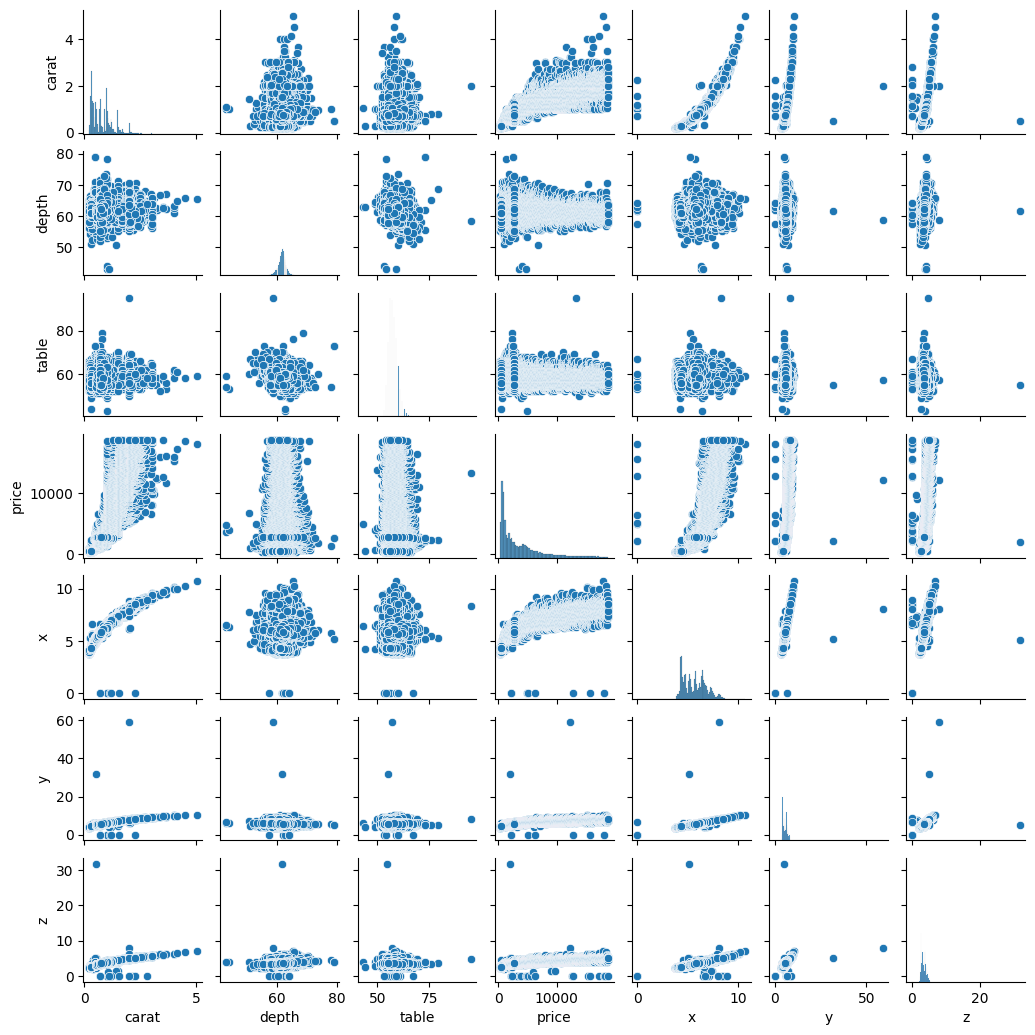

In [137]:
diamonds_num = diamonds.select_dtypes(include=np.number)
sns.pairplot(diamonds_num, height=1.5);

> **Note:** As we progress with manipulating the data, we can come back to this visualization and see how the story unravels.

## Cleaning

This step makes sure only relevant data is collected.

### Dropping non-physical diamonds

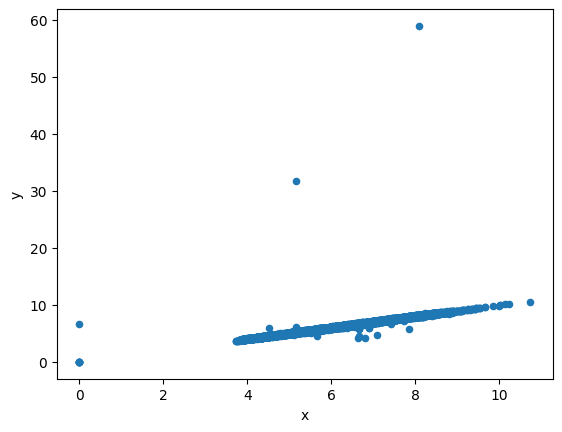

In [138]:
diamonds.plot.scatter('x', 'y');

In [139]:
def drop_zeros(df):
    return df.loc[df.x * df.y * df.z != 0]

In [140]:
zeros_dropper = FunctionTransformer(drop_zeros, validate=False)

In [141]:
diamonds = zeros_dropper.fit_transform(diamonds)

In [142]:
diamonds.shape

(53920, 10)

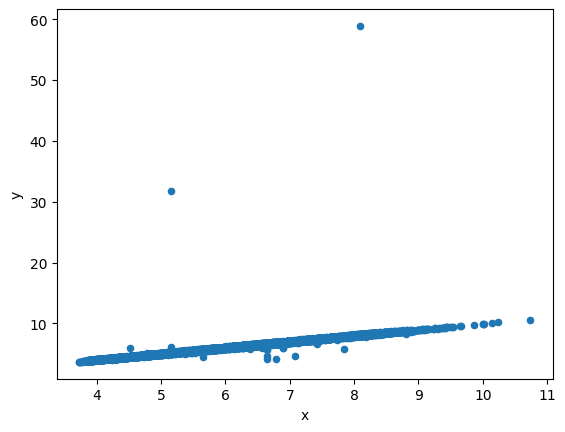

In [143]:
diamonds.plot.scatter('x', 'y');

### Removing non-round diamonds

In [144]:
def select_round(X, diff_max=0.1):
    return X.loc[(X.x - X.y).abs() < diff_max]

In [145]:
cut_rounder = FunctionTransformer(select_round, validate=False, kw_args={'diff_max': 0.1})

In [146]:
diamonds = cut_rounder.fit_transform(diamonds)

In [147]:
diamonds.shape

(52004, 10)

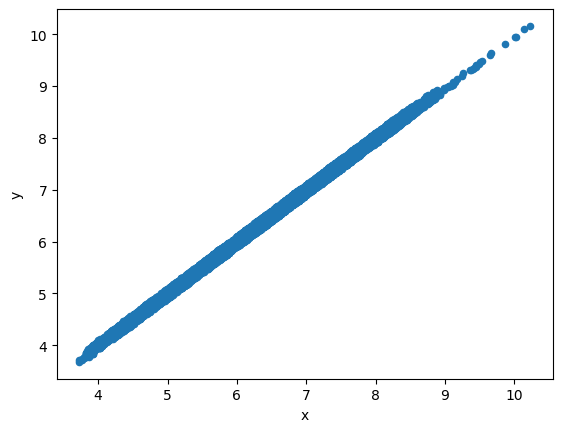

In [148]:
diamonds.plot.scatter('x', 'y');

### Removing outliers

#### 6-sigma range

In [149]:
for col in diamonds.columns:
    if diamonds[col].dtype == 'float64':
        std = diamonds[col].std()
        ave = diamonds[col].mean()
        diamonds = diamonds.loc[diamonds[col].between(ave-3*std, ave+3*std)]
        print(f'processing {col:10} --> {diamonds.shape[0]:5} diamonds remain')

processing carat      --> 51543 diamonds remain
processing depth      --> 50918 diamonds remain
processing table      --> 50524 diamonds remain
processing x          --> 50524 diamonds remain
processing y          --> 50524 diamonds remain
processing z          --> 50520 diamonds remain


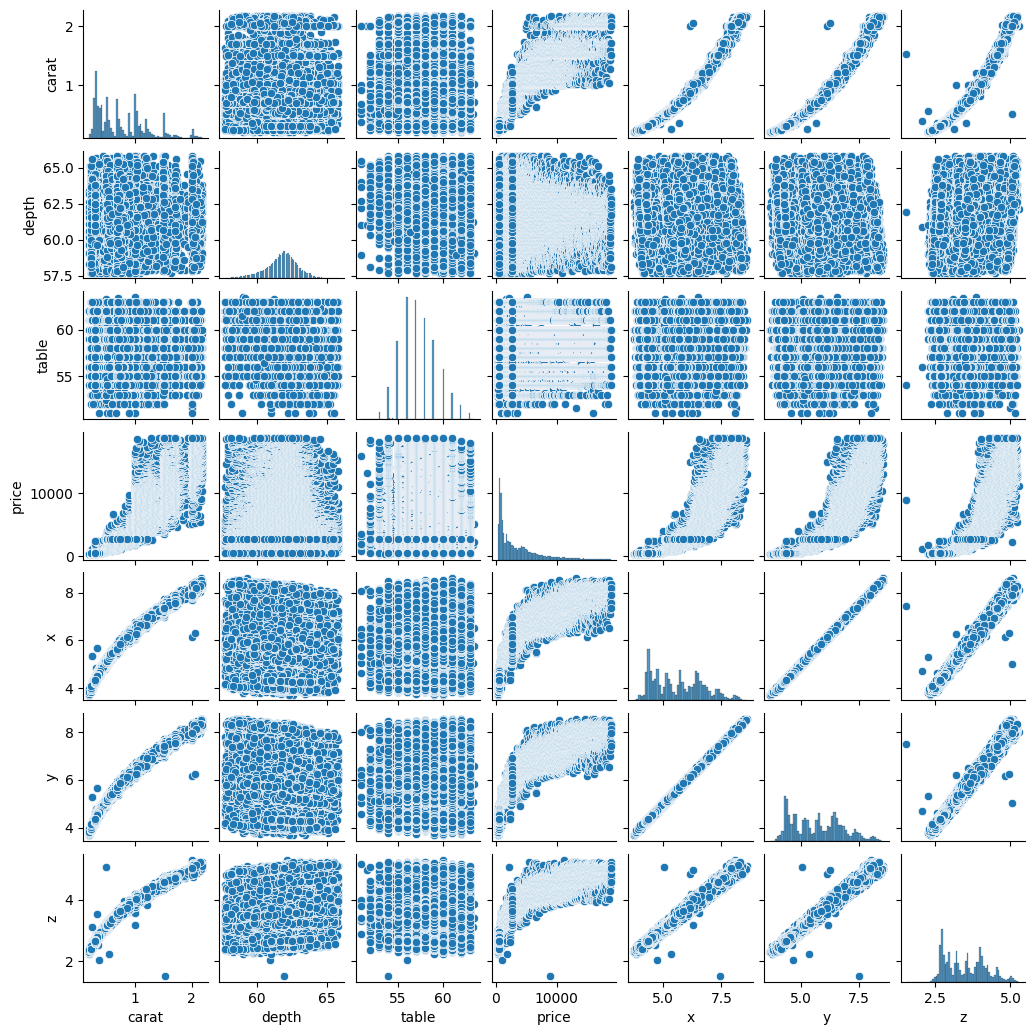

In [150]:
diamonds_num = diamonds.select_dtypes(include=np.number)
sns.pairplot(diamonds_num, height=1.5);

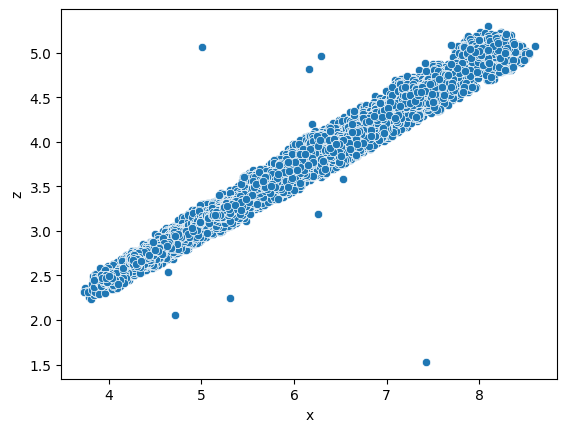

In [151]:
sns.scatterplot(x='x', y='z', data=diamonds);

The problematic data points can be removed manually, but...

In [152]:
from scipy.optimize import curve_fit

def line(x, a, b):
    return a+b*x

(a,b), _ = curve_fit(line, diamonds.x, diamonds.z)

eps = 0.35
diamonds.x.apply(line, a=a, b=b)
diamonds = diamonds.loc[~((diamonds.x.apply(line, a=a, b=b)-diamonds.z).abs() > eps),:]

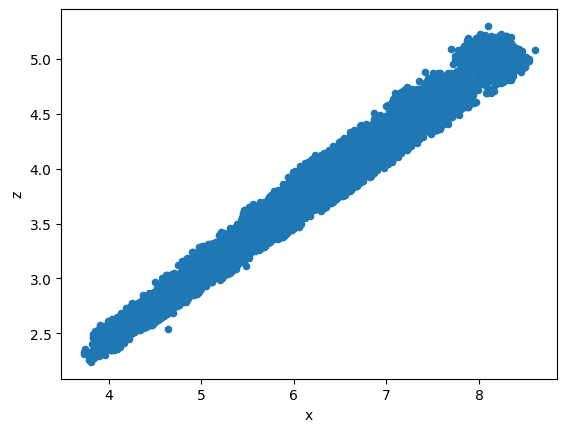

In [153]:
diamonds.plot.scatter(x='x',y='z');

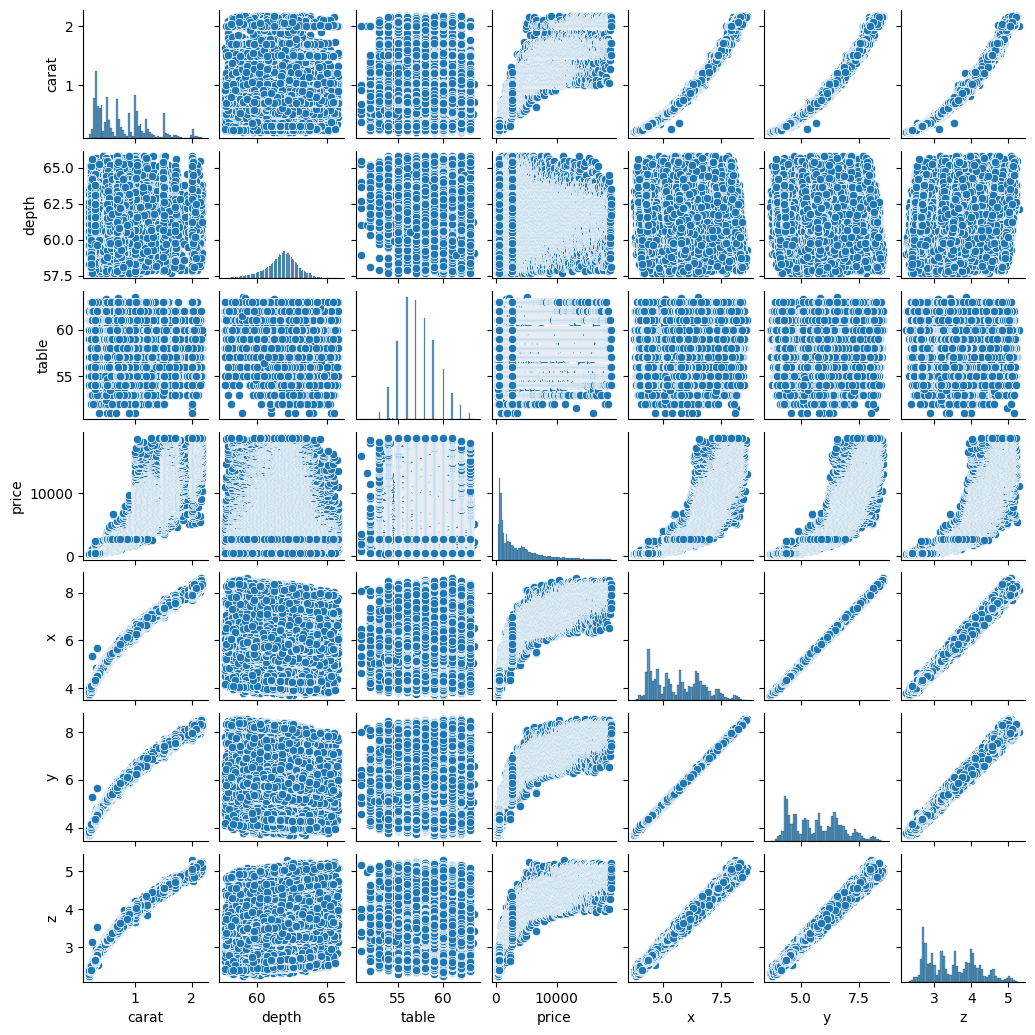

In [154]:
diamonds_num = diamonds.select_dtypes(include=np.number)
sns.pairplot(diamonds_num, height=1.5);

## Feature Selection

For many practical reasons it is always a good idea to reduce the number of features. One of the methods of doing that is by removing features completely.

In [155]:
diamonds.sample(5)

carat        cut color clarity  depth  table  price     x     y     z
31817   0.31      Ideal     F    VVS2   61.5   56.0    775  4.35  4.37  2.68
32746   0.33      Ideal     D     VS2   60.7   56.0    803  4.48  4.50  2.73
27073   1.67      Ideal     F     VS2   61.8   57.0  17194  7.58  7.62  4.70
44509   0.52      Ideal     D     SI1   60.0   56.0   1600  5.19  5.24  3.13
23010   1.51  Very Good     H     VS2   60.9   57.0  11068  7.39  7.43  4.51

### Relevance

Often, some features are not necessary for the problem at hand and can be omitted. This is arguably the most critical part of simplifying the data.

### Correlation

Many times columns are closely related to other columns and therefore can be dropped. This is usually more relevant to numerical data, so we use [`select_dtypes()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.select_dtypes.html).

It is clear that `x`, `y` and `z` are highly linearly correlated, and this can be confirmed by evaluating the linear correlation between them using the [`corr()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) method. This is usually visualized using a heat map.

In [156]:
diamonds.select_dtypes('number').corr()

carat     depth     table     price         x         y         z
carat  1.000000  0.013970  0.186483  0.923555  0.981895  0.981381  0.980922
depth  0.013970  1.000000 -0.277449 -0.016804 -0.031025 -0.032787  0.076980
table  0.186483 -0.277449  1.000000  0.134039  0.192133  0.187753  0.160208
price  0.923555 -0.016804  0.134039  1.000000  0.885301  0.886269  0.881525
x      0.981895 -0.031025  0.192133  0.885301  1.000000  0.999102  0.993721
y      0.981381 -0.032787  0.187753  0.886269  0.999102  1.000000  0.993523
z      0.980922  0.076980  0.160208  0.881525  0.993721  0.993523  1.000000

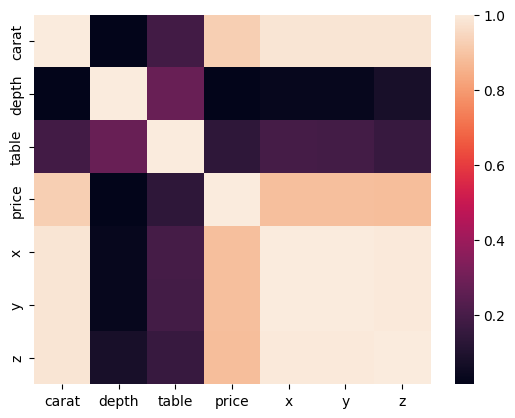

In [157]:
sns.heatmap(diamonds.select_dtypes('number').corr().abs());

Due to the high correlation we decide to drop all dimensions besides the `carat`.

In [158]:
diamonds.drop(['x', 'y', 'z'], axis=1, inplace=True)

In [159]:
diamonds.head()

carat        cut color clarity  depth  table  price
1   0.23      Ideal     E     SI2   61.5   55.0    326
2   0.21    Premium     E     SI1   59.8   61.0    326
4   0.29    Premium     I     VS2   62.4   58.0    334
5   0.31       Good     J     SI2   63.3   58.0    335
6   0.24  Very Good     J    VVS2   62.8   57.0    336

## Preprocessing

In [160]:
diamonds.shape

(50511, 7)

### Scaling

#### Features

For many reasons, it is often advisable to scale the features. One of the reasons is to make sure that none of the featrues "shadows" the others.

Based on [This diamonds explanation](https://rstudio-pubs-static.s3.amazonaws.com/316651_5c92e58ef8a343e4b3f618a7b415e2ad.html), we know that `depth` and `table` actually represent ratios, so we can simply divide them by $100$.

In [161]:
diamonds[['depth', 'table']] = diamonds[['depth', 'table']] / 100

In [162]:
diamonds.head()

carat        cut color clarity  depth  table  price
1   0.23      Ideal     E     SI2  0.615   0.55    326
2   0.21    Premium     E     SI1  0.598   0.61    326
4   0.29    Premium     I     VS2  0.624   0.58    334
5   0.31       Good     J     SI2  0.633   0.58    335
6   0.24  Very Good     J    VVS2  0.628   0.57    336

#### Target

<Axes: >

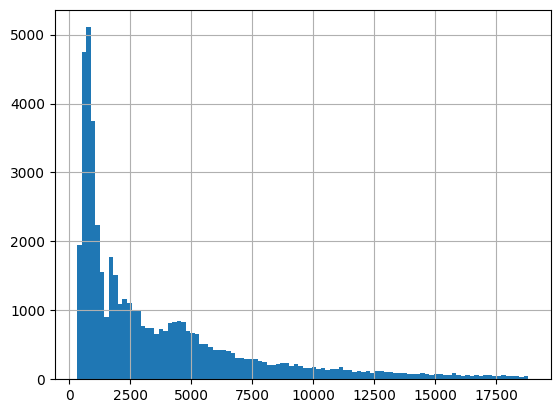

In [163]:
diamonds.price.hist(bins=100)

Normalized the data by applying a logarithmic transformation to the price column to create a more sensible data distribution for the model. The predicted results from the model will need to be converted back from the log to obtain the actual results.

In our case, the target distribution (`price`) has a long tail at the high values, so we can apply the log transformation, conveniently implemented by [`np.log1p()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.log1p.html).

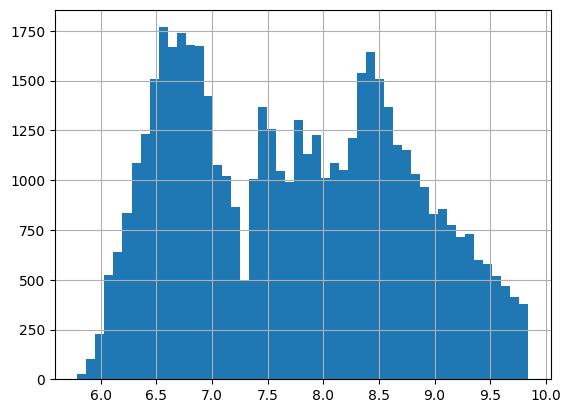

In [164]:
log_price = np.log1p(diamonds.price)
log_price.hist(bins=50);

In [165]:
diamonds['price'] = log_price
diamonds.rename({'price': 'log_price'}, inplace=True, axis=1)

In [166]:
diamonds.head()

carat        cut color clarity  depth  table  log_price
1   0.23      Ideal     E     SI2  0.615   0.55   5.789960
2   0.21    Premium     E     SI1  0.598   0.61   5.789960
4   0.29    Premium     I     VS2  0.624   0.58   5.814131
5   0.31       Good     J     SI2  0.633   0.58   5.817111
6   0.24  Very Good     J    VVS2  0.628   0.57   5.820083

> **Note:** We note specifically that the RMSE of the `log_price` predictions is equivalent to the RMSLE of the `price` predictions.

### Categorical data

All models expect numerical input, therefore it is mandatory to transform the categorical data into numerical data. There are several technique to do that, however the method should be selected on the context of the entire pipeline.

For simplicity we will use the most simple manipulation, assigning an *ordinal* number to each category.

In [167]:
cut_order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
cut_map = dict(zip(cut_order, range(len(cut_order))))

color_order = ['J', 'I', 'H', 'G', 'F', 'E', 'D']
color_map = dict(zip(color_order, range(len(color_order))))

clarity_order = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']
clarity_map = dict(zip(clarity_order, range(len(clarity_order))))

In [168]:
diamonds['cut'] = diamonds['cut'].map(cut_map)
diamonds['color'] = diamonds['color'].map(color_map)
diamonds['clarity'] = diamonds['clarity'].map(clarity_map)

In [169]:
diamonds.head()

carat  cut  color  clarity  depth  table  log_price
1   0.23    4      5        1  0.615   0.55   5.789960
2   0.21    3      5        2  0.598   0.61   5.789960
4   0.29    3      1        3  0.624   0.58   5.814131
5   0.31    1      0        1  0.633   0.58   5.817111
6   0.24    2      0        5  0.628   0.57   5.820083

In [170]:
diamonds.shape

(50511, 7)

## Splitting the data

For validation purposes we split the data. It is a common convention that the features are denoted by $X$ and the target is denoted by $y$.

In [171]:
X = diamonds.drop('log_price', axis=1)
y = diamonds.log_price

The *train* part is used for training the model, and the *test* part is used for validation.

In [172]:
X_train, X_test, y_train, y_test = split(X, y, test_size=0.3)

In [173]:
X_train.head(3)

carat  cut  color  clarity  depth  table
27611   2.16    3      1        3  0.587   0.60
48068   0.51    3      6        3  0.580   0.60
5797    1.01    2      0        1  0.628   0.59

In [174]:
y_train.head(3)

27611    9.824553
48068    7.564757
5797     8.270525
Name: log_price, dtype: float64

# Linear regression

## Fitting the model

First we create the model

In [175]:
lin_model_1 = LinearRegression(fit_intercept=False)

Then we **fit** it...

In [176]:
lin_model_1.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

Now we can inspect the model...

In [177]:
lin_model_1.intercept_

0.0

In [178]:
list(zip(X_train.columns, lin_model_1.coef_))

[('carat', 2.324762750120621),
 ('cut', 0.05993358405422722),
 ('color', 0.08948015403695997),
 ('clarity', 0.09428657026051923),
 ('depth', 5.509731717560588),
 ('table', 3.100908782788742)]

## Predicting with the model

In [179]:
y_train_pred = lin_model_1.predict(X_train)

### Evaluating the model

In [180]:
pd.DataFrame({'Predictions': y_train_pred, 'Actual': y_train.values})

Predictions    Actual
0        10.668386  9.824553
1         7.241360  7.564757
2         7.851812  8.270525
3         7.001030  6.818924
4         7.299351  7.491645
...            ...       ...
35352     9.593264  9.128696
35353     7.022050  7.250636
35354     8.353488  8.662851
35355     6.730991  6.688355
35356     7.085289  6.928538

[35357 rows x 2 columns]

We use the *Predicted vs. Actual* visualization, where the red line stands for a "Perfect" prediction model.

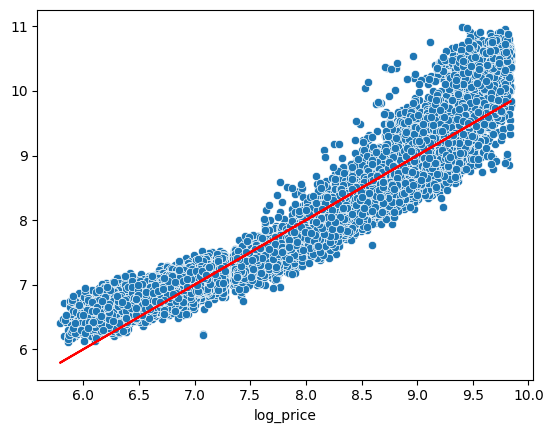

In [181]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r');

Finally, we can score our model

In [189]:
rmse(y_train, y_train_pred)

0.31349595063905006

### Validating the model

Let's see how does the model work for the test data...

In [183]:
y_test_pred = lin_model_1.predict(X_test)

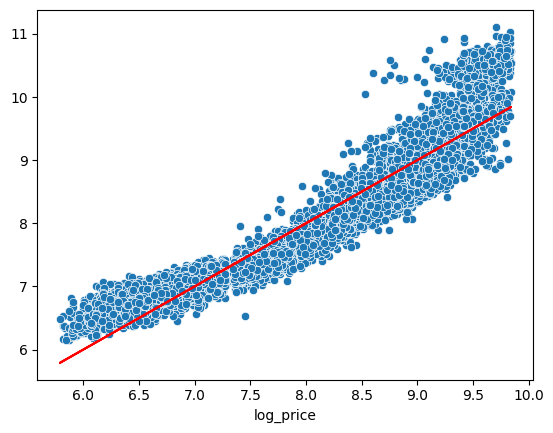

In [184]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r');

In [ ]:
RMSLE = rmse(y_test, y_test_pred)
RMSLE

The test score is very close to the train score, therefore **the model is valid!**

# Decision Trees

## First shot

### Fit the model

In [ ]:
X = diamonds.drop('log_price', axis=1)
y = diamonds.log_price

In [ ]:
X_train, X_test, y_train, y_test = split(X, y, test_size=0.3)

In [ ]:
dt_model_1 = DecisionTreeRegressor()
dt_model_1.fit(X_train, y_train)

### Inspect the model

We write a small function to help us visualize the trees.

In [ ]:
def visualize_tree(model, md=5, fs=(12, 8)):
    plt.figure(figsize=fs)
    plot_tree(model,
            max_depth=md,
            feature_names=model.feature_names_in_,
            label='all',
            filled=True,
            rounded=True,
            fontsize=12);

In [ ]:
X_train.head()

In [ ]:
visualize_tree(dt_model_1, md=5, fs=(20, 14))

> **Note:** The default hyper-parameters are set to overfitting, therefore the tree is enormous, so we cut the tree in the figure.

### Predicting with the model

In [ ]:
y_train_pred = dt_model_1.predict(X_train)

#### Evaluating the model

In [ ]:
pd.DataFrame({'Predictions': y_train_pred, 'Actual': y_train.values})

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r');

In [193]:
RMSLE = rmse(y_train, y_train_pred)
RMSLE

0.31349595063905006

#### Validating the model

Let's see how does the model work for the test data...

In [ ]:
y_test_pred = dt_model_1.predict(X_test)

In [ ]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r');

In [194]:
RMSLE = rmse(y_test, y_test_pred)
RMSLE

0.315893393206216

> **Conclusion:** The model is overfitted.

## Overfitting

In [198]:
sub_diamonds = diamonds.sample(1000)
sub_X = sub_diamonds.drop('log_price', axis=1)
sub_y = sub_diamonds.log_price
sub_X_train, sub_X_test, sub_y_train, sub_y_test = split(sub_X, sub_y, random_state=1415)

For this example we will look what happens to the train error and test error when we tune the hyper-parameter called `max_leaf_nodes`.

In [207]:
complexity = range(2, 201 , 1)
scores = pd.DataFrame(index=complexity, columns=['train', 'test'])

for leafs in complexity:
    model = DecisionTreeRegressor(max_leaf_nodes=leafs).fit(sub_X_train, sub_y_train)

    sub_y_train_pred = model.predict(sub_X_train)
    scores.loc[leafs, 'train'] = rmse(sub_y_train_pred, sub_y_train)

    sub_y_test_pred = model.predict(sub_X_test)
    scores.loc[leafs, 'test'] = rmse(sub_y_test_pred, sub_y_test)

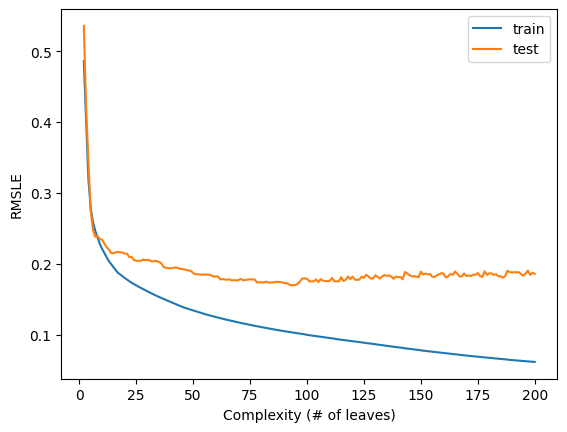

In [203]:
scores.plot(xlabel='Complexity (# of leaves)', ylabel='RMSLE');

> Note that the effect of overfitting is more critical when the data is more diverse and noisy. The diamonds dataset is not detailed enough for this issue to be observable.

There are several methods for dealing with overfitting, including dimensionality reduction, regularization and ensemble models. Decision trees are known for having many regularization hyper-parameters, and for our next model we explore them in order to have a more regular model.

## Second model

### Fit the model

Next we take some of the regularization **hyperparameters** and add constraints to the tree.

In [204]:
dt_model_2 = DecisionTreeRegressor(min_samples_leaf=50, max_leaf_nodes=150)

In [205]:
dt_model_2.fit(X_train, y_train)

DecisionTreeRegressor(max_leaf_nodes=150, min_samples_leaf=50)

### Inspect the model

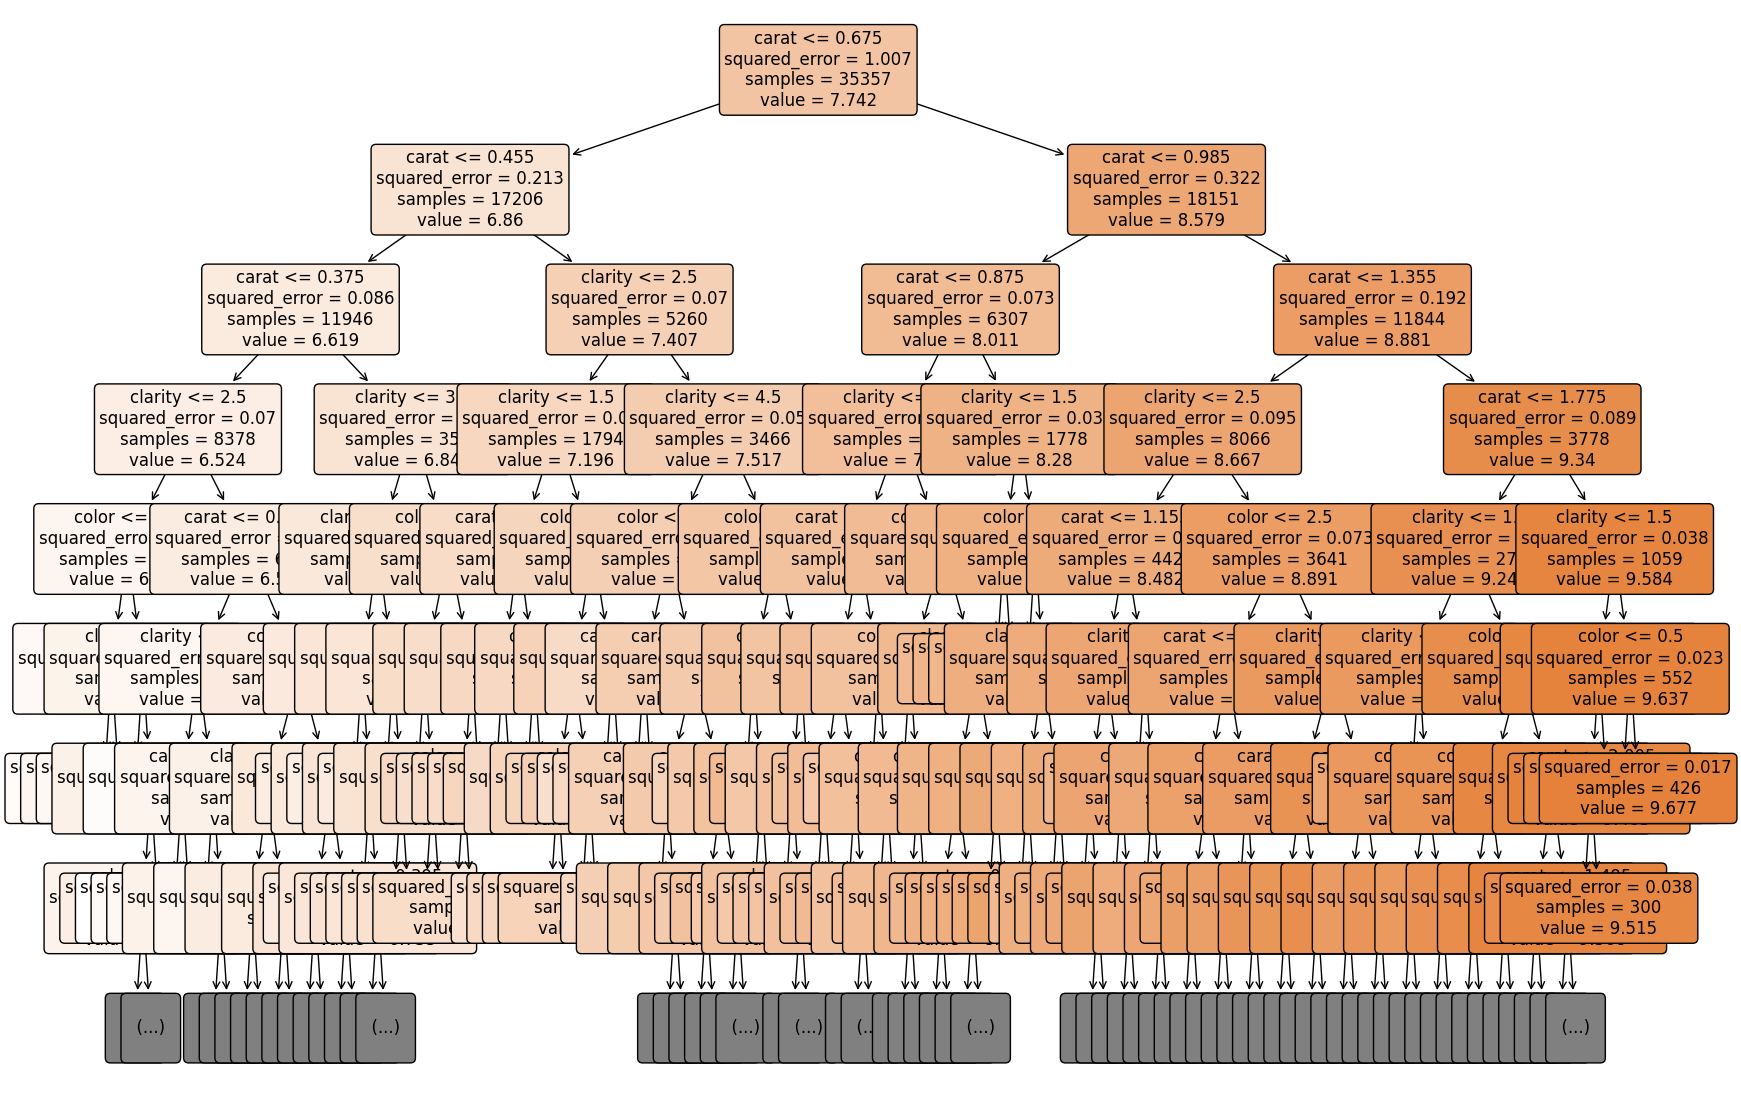

In [206]:
visualize_tree(dt_model_2, md=7, fs=(20, 14))

### Predicting with the model

In [208]:
y_train_pred = dt_model_2.predict(X_train)

In [209]:
pd.DataFrame({'Predictions': y_train_pred, 'Actual': y_train.values})

Predictions    Actual
0         9.677181  9.824553
1         7.456835  7.564757
2         8.243249  8.270525
3         6.677175  6.818924
4         7.478558  7.491645
...            ...       ...
35352     8.947637  9.128696
35353     7.324693  7.250636
35354     8.676233  8.662851
35355     6.501782  6.688355
35356     6.808055  6.928538

[35357 rows x 2 columns]

#### Evaluating the model

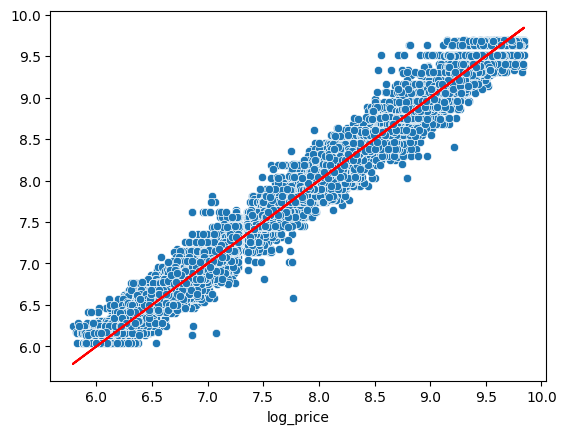

In [210]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r');

In [212]:
RMSLE = rmse(y_train, y_train_pred)
RMSLE

0.12932633712647112

#### Validating the model

In [213]:
y_test_pred = dt_model_2.predict(X_test)

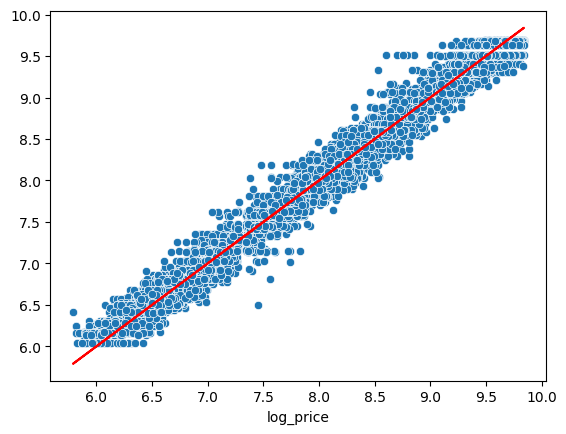

In [214]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')

In [217]:
RMSLE = rmse(y_test, y_test_pred)
RMSLE

0.13089001895282107

Our model is now valid.

## Explainability

### Feature importance

Another useful inspection of a model is to look at the "importance" it corresponds to each feature. This can have many meanings, but for tree-based models it represents the relative accumulated success contributed by each feature.

In [218]:
pd.Series(dt_model_2.feature_importances_,
          index=X_train.columns).sort_values(ascending=False)#.plot.bar()

carat      0.956081
clarity    0.029668
color      0.013791
cut        0.000460
depth      0.000000
table      0.000000
dtype: float64

# K-Nearest Neighbors

## First shot

In [219]:
X_train.head(5)

carat  cut  color  clarity  depth  table
27611   2.16    3      1        3  0.587   0.60
48068   0.51    3      6        3  0.580   0.60
5797    1.01    2      0        1  0.628   0.59
35798   0.34    4      4        5  0.618   0.56
46701   0.55    3      3        4  0.594   0.62

In [220]:
knn_model_1 = KNeighborsRegressor(n_neighbors=10, )
knn_model_1.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=10)

### Predicting with the model

In [221]:
y_train_pred = knn_model_1.predict(X_train)

In [222]:
pd.DataFrame({'Predictions': y_train_pred, 'Actual': y_train.values})

Predictions    Actual
0         9.731970  9.824553
1         7.510097  7.564757
2         8.206308  8.270525
3         6.758084  6.818924
4         7.521825  7.491645
...            ...       ...
35352     9.122067  9.128696
35353     7.232092  7.250636
35354     8.610985  8.662851
35355     6.525334  6.688355
35356     6.877802  6.928538

[35357 rows x 2 columns]

#### Evaluating the model

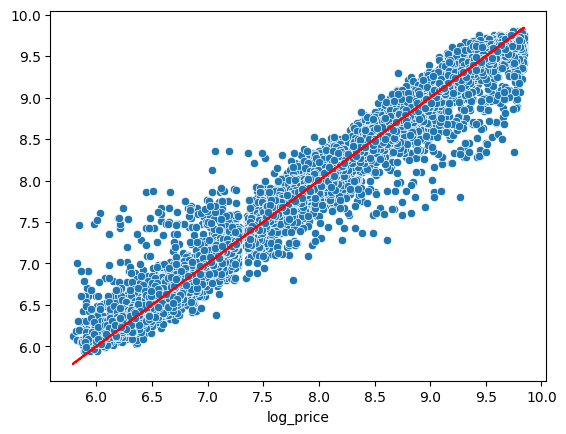

In [223]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r');

In [224]:
RMSE = rmse(y_train, y_train_pred)
RMSE

0.13160126858551063

#### Validating the model

Let's see how does the model work for the test data...

In [225]:
y_test_pred = knn_model_1.predict(X_test)

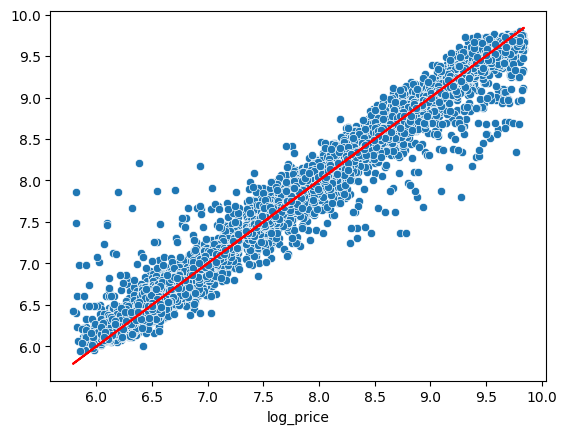

In [226]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r');

In [227]:
RMSLE = rmse(y_test, y_test_pred)
RMSLE

0.14754168341435722

The test score is very close to the train score, therefore **the model is valid!**

## Second model

### Scaling the data

In [228]:
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler

In [229]:
X_train.head()

carat  cut  color  clarity  depth  table
27611   2.16    3      1        3  0.587   0.60
48068   0.51    3      6        3  0.580   0.60
5797    1.01    2      0        1  0.628   0.59
35798   0.34    4      4        5  0.618   0.56
46701   0.55    3      3        4  0.594   0.62

The default metric is the Euclidean one. This means that the categorical data has much more influence.
We have two options to deal with this situation - scaling our data or modifying the metric (or both).

In [230]:
my_scaler = MaxAbsScaler().fit(X_train)
X_train_scaled = pd.DataFrame(my_scaler.transform(X_train), columns=X_train.columns)
X_train_scaled.head()

carat   cut     color   clarity     depth     table
0  0.990826  0.75  0.166667  0.428571  0.892097  0.944882
1  0.233945  0.75  1.000000  0.428571  0.881459  0.944882
2  0.463303  0.50  0.000000  0.142857  0.954407  0.929134
3  0.155963  1.00  0.666667  0.714286  0.939210  0.881890
4  0.252294  0.75  0.500000  0.571429  0.902736  0.976378

### Fit the model

In [231]:
knn_model_2 = KNeighborsRegressor(n_neighbors=10)
knn_model_2.fit(X_train_scaled, y_train)

KNeighborsRegressor(n_neighbors=10)

In [232]:
y_train_pred = knn_model_2.predict(X_train_scaled)

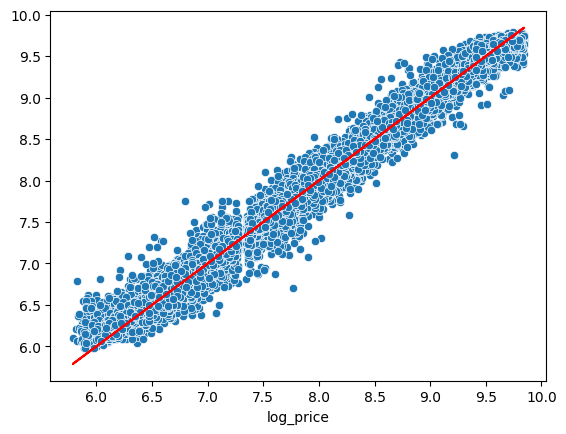

In [233]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r');

In [234]:
RMSLE = rmse(y_train, y_train_pred)
RMSLE

0.112796154832217

### Validating the model

Let's see how does the model work for the test data...

In [235]:
X_test_scaled = my_scaler.transform(X_test)

In [236]:
y_test_pred = knn_model_2.predict(X_test_scaled)

c:\Users\elhaia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


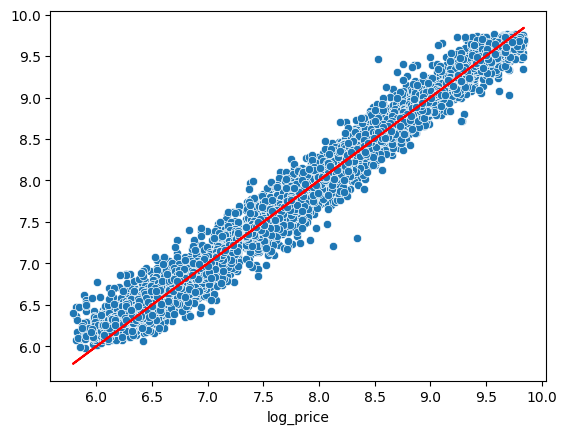

In [237]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r');

In [238]:
RMSLE = rmse(y_test, y_test_pred)
RMSLE

0.12489228258571144

# SVM Model

In [239]:
X = diamonds.drop('log_price', axis=1)
y = diamonds.log_price
X_train, X_test, y_train, y_test = split(X, y, test_size=0.3)

In [240]:
from sklearn.svm import SVR
svm_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
# Train the SVM model using your training data
svm_model.fit(X_train, y_train)

SVR()

In [241]:
y_train_pred = knn_model_1.predict(X_train)

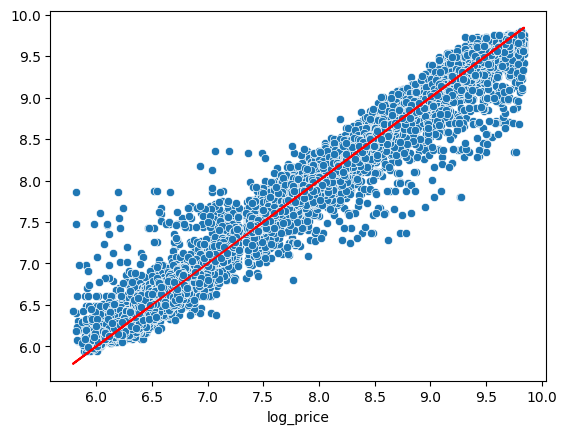

In [242]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r');

In [243]:
RMSE = rmse(y_train, y_train_pred)
RMSE

0.13669313793207757

### Validating the model

In [244]:
y_test_pred = knn_model_1.predict(X_test)

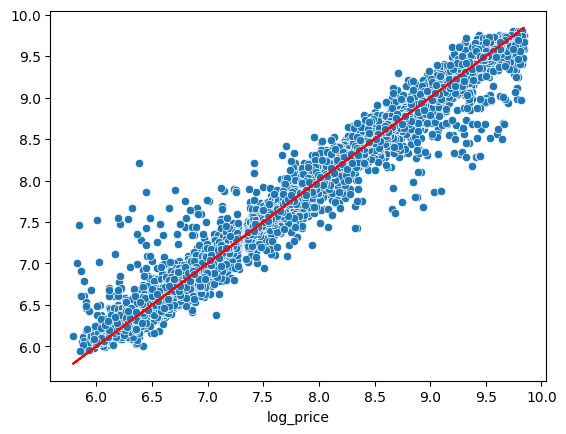

In [245]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r');

In [246]:
RMSLE = rmse(y_test, y_test_pred)
RMSLE

0.13631267442585793

The test score is very close to the train score, therefore **the model is valid!**